## Adding utility function to return RGB image from BGR image 

In [1]:
import cv2
def get_mp_image( cv2Image):
    b,g,r = cv2.split( cv2Image )
    mp_image = cv2.merge([r,g,b])
    return mp_image

In [2]:
#initialize
DIST_COEFF = None
DIST_MATRIX = None
PERSPECTIVE_MATRIX = None
INV_PERSPECTIVE_MATRIX = None

## Camera Calibration 

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np

#function to get calibration matrix, distortion coefficients by using cv2.calibrateCamera on the supplied image
def calibrate_camera(img, dest_file):
    plt.figure(figsize=(10,10))
    objpoints=[]
    imgpoints=[]

    objp=np.zeros((9*6,3),dtype=np.float32)
    objp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    #convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #find chessboard corners
    ret, corners = cv2.findChessboardCorners( gray,(9,6),None)
    #if findChessboardCorners is successful
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)
        #draw chessboard corners
        cv2.drawChessboardCorners( gray, (9,6), corners, ret )
        #show original image
        plt.subplot(2,1,1)
        plt.imshow(img)
        
        #calibrate the camera and get the calibration matrix, distortion coefficients, rotational & translational vectors
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        undstrt_img = cv2.undistort(img, mtx, dist, None, mtx)
        
#         src_points = np.float32([corners[0], corners[8], corners[-1], corners[-9]])        
#         offset=100
#         dest_points = np.float32([[offset,offset], [img.shape[1]-offset,offset],
#                 [img.shape[1]-offset,img.shape[0]-offset], [offset,img.shape[0]-offset]])        
#         M = cv2.getPerspectiveTransform(src_points,dest_points)
#         warped = cv2.warpPerspective(undstrt_img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR )

        plt.subplot(2,1,2)
        #show undistorted image
        plt.imshow(undstrt_img)
        cv2.imwrite(dest_file, undstrt_img)
        print('Output Image saved to',dest_file)
    plt.show()
    #returning the calibration matrix, distortion coefficients
    return dist,mtx

### Test calibrate_camera function, and get DIST_COEFF, DIST_MATRIX

Output Image saved to ./output_images/calibration2.jpg


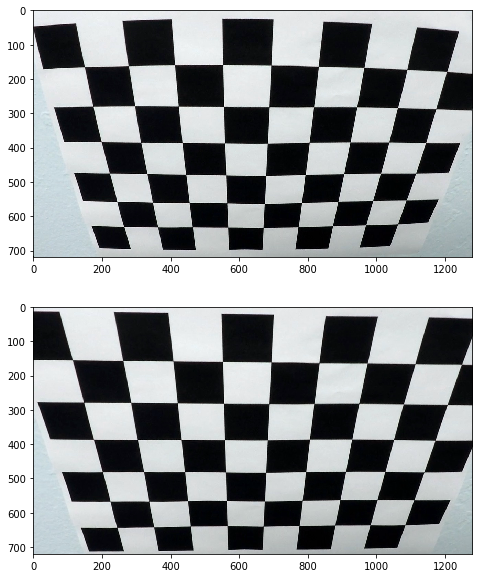

In [4]:
#read image from file
image = cv2.imread('./camera_cal/calibration2.jpg')
#get calibration matrix, distortion coefficients
DIST_COEFF, DIST_MATRIX = calibrate_camera(image,'./output_images/calibration2.jpg')
    
    

## Perspective Transform 

In [5]:
import cv2
import matplotlib.pyplot as plt

#apply perspective transform
def apply_perspective( img ):
    img = cv2.undistort(img, DIST_MATRIX, DIST_COEFF, None, DIST_MATRIX)
    src_points = np.float32([[575,460],  [705,460], [1060,680], [220,680]])
    bottom_left = [220,720] 
    bottom_right = [1060, 720]
    top_left = [220, 1]
    top_right = [1060, 1]  
    offset=100
    dest_points = np.float32([top_left, top_right, bottom_right, bottom_left])        
    M = cv2.getPerspectiveTransform(src_points,dest_points)
    Minv = cv2.getPerspectiveTransform(dest_points,src_points)
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR )
    return M, warped, Minv

### Test apply_perspective function, and get PERSPECTIVE_MATRIX, INV_PERSPECTIVE_MATRIX

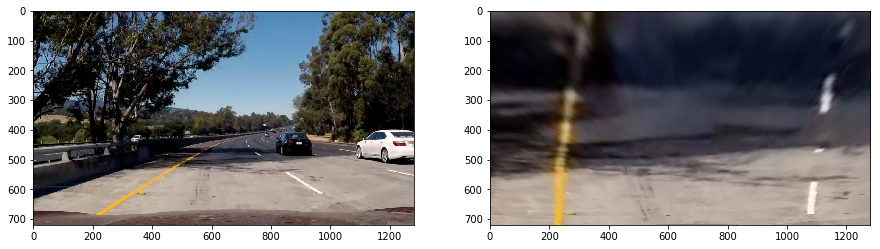

In [6]:
image = cv2.imread('./test_images/test5.jpg')
if image.shape:
    PERSPECTIVE_MATRIX, warped_image, INV_PERSPECTIVE_MATRIX = apply_perspective( image )
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.imshow(get_mp_image(image))
    plt.subplot(1,2,2)
    plt.imshow(get_mp_image(warped_image))
    plt.show()

## Color and Gradient Thresholding 

In [130]:
import numpy as np

def saturation_direction_magnitude(s_channel, d_threshold=(0, np.pi / 2), m_threshold=(0, 255), sobel_kernel=3):
    # Taking the gradient in x and y separately
    sobel_x = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the magnitude
    magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    magnitude = (magnitude * 255 / np.max(magnitude)).astype(np.uint8)
    # Create a binary mask where mag thresholds are met
    m_mask = np.zeros_like(magnitude)
    m_mask[(magnitude >= m_threshold[0]) & (magnitude <= m_threshold[1])] = 1
    
    # Take the absolute value of the x and y gradients and calculate the direction of the gradient
    direction = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    # Create a binary mask where direction thresholds are met
    d_mask = np.zeros_like(direction,dtype=np.uint8)
    # Return this mask as your binary_output image
    d_mask[(direction >= d_threshold[0]) & (direction <= d_threshold[1])] = 1
    
    mask = np.zeros_like(s_channel,dtype=np.uint8)
    mask[((d_mask==1) & (m_mask==1))] = 1
    
    return mask
    

In [169]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
def apply_sobel(img, s_thresh=(170, 245), x_thresh=(50, 120), s_d_thresh=(0.8,1.3), s_m_thresh=(50,100)):
    # Convert to HLS color space and separate the H,S channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    s_channel = hls[:,:,2]
    
    # Sobel x using the grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    x_binary = np.zeros_like(scaled_sobel, dtype=np.uint8)
    x_binary[(scaled_sobel >= x_thresh[0]) & (scaled_sobel <= x_thresh[1])] = 1

    
    # Threshold saturation channel
    s_color = np.zeros_like(s_channel, dtype=np.uint8)
    s_color[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    s_dm = saturation_direction_magnitude(s_channel, s_d_thresh, s_m_thresh)
    
    s_binary = np.zeros_like(s_channel, dtype=np.uint8)
    s_binary[(s_color == 1) | (s_dm == 1)] = 1
    
    # Stack each channel using np.dstack
    color_binary = np.dstack(( np.zeros_like(s_binary, dtype=np.uint8), s_binary, x_binary ))*255
    
    combined_binary = np.zeros_like(x_binary, dtype=np.uint8)
    combined_binary[(s_binary == 1) | (x_binary == 1) ] = 1
    return combined_binary,color_binary

### Test apply_sobel function

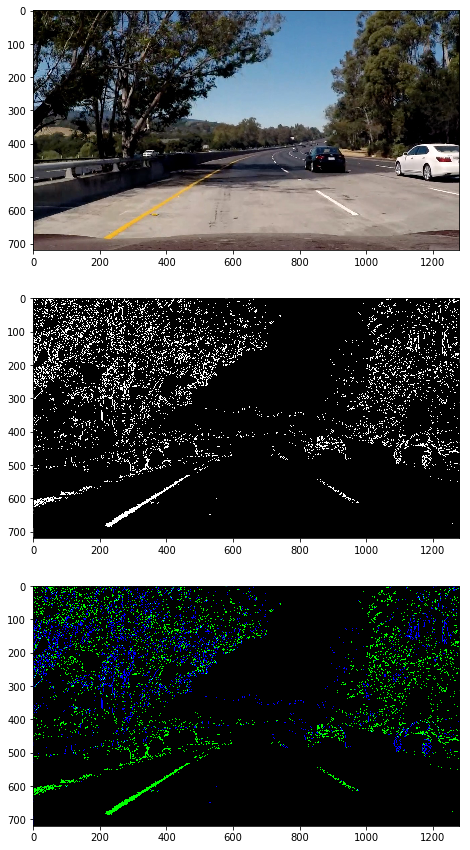

In [170]:
image = cv2.imread('./test_images/test5.jpg')
combined_binary,color = apply_sobel( image )
plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
image_b,image_g,image_r = cv2.split(image)
plt.imshow( cv2.merge([image_r,image_g,image_b]) )
plt.subplot(3,1,2)
plt.imshow( combined_binary, cmap='gray' )
plt.subplot(3,1,3)
# sobel for saturation is green
# sobel for x is red
plt.imshow( color )
plt.show()

## Test preprocessing of image

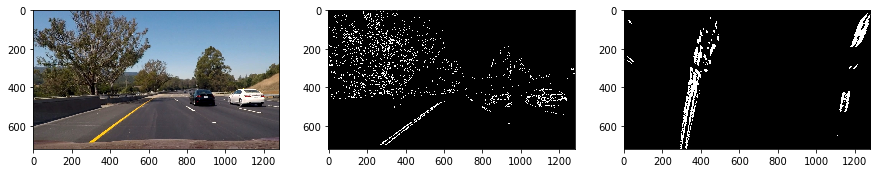

In [175]:
import cv2
import matplotlib.pyplot as plt

def preprocess_image( img ):
    if type(PERSPECTIVE_MATRIX) == None or type(DIST_COEFF) == None or type(DIST_MATRIX) == None or type(INV_PERSPECTIVE_MATRIX) == None:
        print("Pipeline won't work as either one of PERSPECTIVE_MATRIX, DIST_COEFF, DIST_MATRIX, INV_PERSPECTIVE_MATRIX is None")
    else:
        plt.figure(figsize=(15,10))
        plt.subplot(1,3,1)
        plt.imshow(get_mp_image(img))
        
        undistorted_image = cv2.undistort(img, DIST_MATRIX, DIST_COEFF, None, DIST_MATRIX)
        sobeled_image, sobeled_image_color = apply_sobel( undistorted_image, (170,245), (50,150))
        
        plt.subplot(1,3,2)
        plt.imshow(sobeled_image,cmap='gray')
        
        warped_image = cv2.warpPerspective(sobeled_image, PERSPECTIVE_MATRIX, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR )
        
        
        plt.subplot(1,3,3)
        plt.imshow(warped_image,cmap='gray')
        return warped_image
        
image = cv2.imread('./test_images/test6.jpg')
preprocessed_image = preprocess_image( image )